# Water absorption

In [28]:
# imports
from importlib import reload
import numpy as np
from matplotlib import pyplot as plt
import pandas

from ocpy.water import absorption as w_abs
from ocpy.water.WOPP import WOPP 
from ocpy.utils import plotting

# Load up

In [5]:
wave = np.arange(300., 2010., 10)
wave

array([ 300.,  310.,  320.,  330.,  340.,  350.,  360.,  370.,  380.,
        390.,  400.,  410.,  420.,  430.,  440.,  450.,  460.,  470.,
        480.,  490.,  500.,  510.,  520.,  530.,  540.,  550.,  560.,
        570.,  580.,  590.,  600.,  610.,  620.,  630.,  640.,  650.,
        660.,  670.,  680.,  690.,  700.,  710.,  720.,  730.,  740.,
        750.,  760.,  770.,  780.,  790.,  800.,  810.,  820.,  830.,
        840.,  850.,  860.,  870.,  880.,  890.,  900.,  910.,  920.,
        930.,  940.,  950.,  960.,  970.,  980.,  990., 1000., 1010.,
       1020., 1030., 1040., 1050., 1060., 1070., 1080., 1090., 1100.,
       1110., 1120., 1130., 1140., 1150., 1160., 1170., 1180., 1190.,
       1200., 1210., 1220., 1230., 1240., 1250., 1260., 1270., 1280.,
       1290., 1300., 1310., 1320., 1330., 1340., 1350., 1360., 1370.,
       1380., 1390., 1400., 1410., 1420., 1430., 1440., 1450., 1460.,
       1470., 1480., 1490., 1500., 1510., 1520., 1530., 1540., 1550.,
       1560., 1570.,

## Pure water

In [29]:
wl, pure, _ = WOPP.absorption(300., 2000., 0., T)

## Salty water

In [12]:
S = 35. # PSU
T = 15. # Celsius

In [16]:
reload(WOPP)
wl, salty, _ = WOPP.absorption(wave.min(), wave.max(), S, T)

## Add CDOM

In [19]:
def a_cdom(wave, a440, Sdg=0.0125):
    i440 = np.argmin(np.abs(wave-440.))
    return a440 * np.exp(-Sdg * (wave-440.))

In [20]:
cdom = salty + a_cdom(wl, 1.)

# Plots

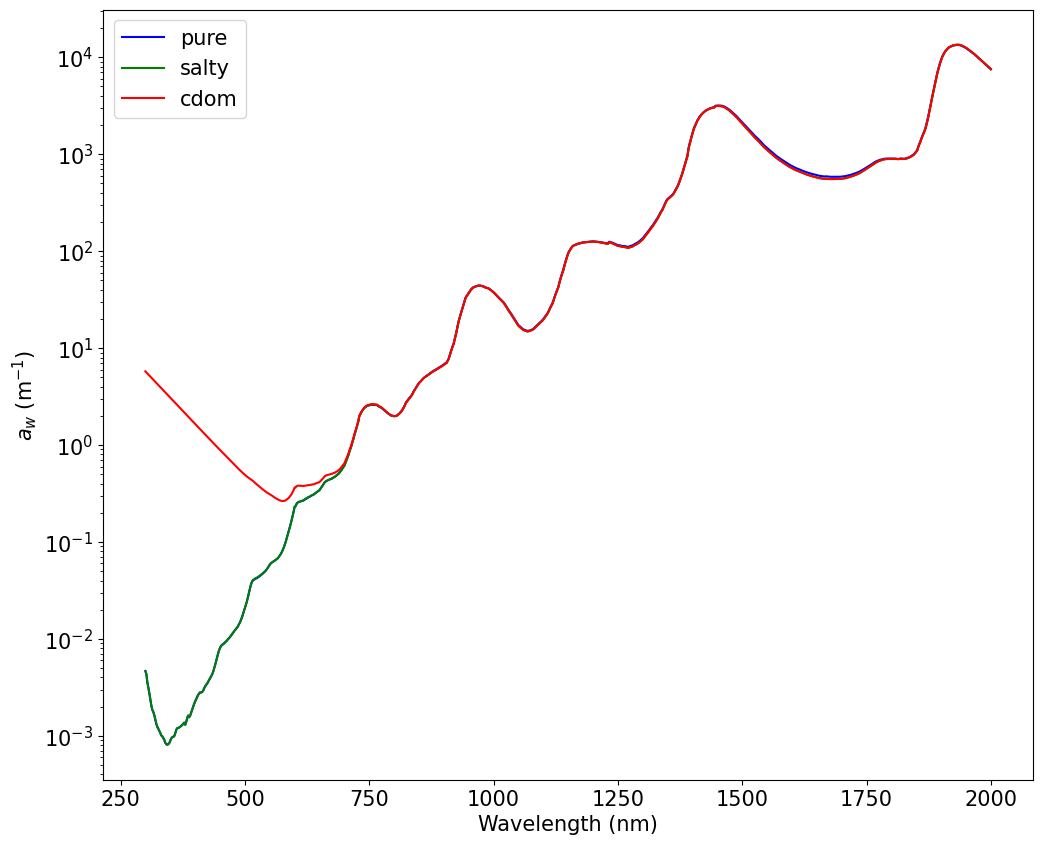

In [31]:
fig = plt.figure(figsize=(12,10))
ax = plt.gca()
#
ax.plot(wl, pure, label='pure', c='b')
ax.plot(wl, salty, label='salty', c='g')
ax.plot(wl, cdom, label='cdom', c='r')
#
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel(r'$a_w$ (m$^{-1}$)')
#
ax.set_yscale('log')
ax.legend(fontsize=15.)
#
plotting.set_fontsize(ax, 15.)
#
plt.show()

In [ ]:
## Interpolate pure onto the other grid

# Generate table

In [32]:
df = pandas.DataFrame()
df['wl'] = wl
df['pure'] = pure
df['salty'] = salty
df['cdom'] = cdom

## Write

In [ ]:
df.to_csv('a_w_for_andy.csv'